In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# EDA 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
ss = pd.read_csv('data/sample_submission.csv')

In [3]:
# 컬럼명 영문으로 변경하기
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [4]:
train_df.shape

(122400, 10)

In [5]:
train_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


비가 오는 날과 맑은 날의 전력 사용량에 차이가 날 것 이라 생각이 들었고, 날씨와 전력 사용량의 상관 관계를 알아보면 좋겠다는 생각이 들었습니다.

그래서 weather이라는 컬럼을 새로 만들고, 비오는 날을 0, 흐린 날을 0.5, 맑은 날을 1로 값을 주었습니다.

- 비오는날
    - 강수량 > 0
- 흐린 날
    - 강수량 = 0, 일조량
- 맑은 날
    - 강수량 = 0, 일조량 = 1
    - 강수량 = 0, 일조량 = 0 , 습도 
    
흐린 날과, 맑은 날의 데이터를 뽑기 위해 일조량과 습도를 알아내고 싶었습니다.

그래서 비오는 날의 dataframe과 비가 오지 않는 날의 dataframe을 뽑아내고, 습도, 강수량, 일조에 대한 데이터를 뽑아 보았습니다.

In [6]:
rainy_df = train_df[train_df['precipitation']>0]

print(rainy_df.shape)

(18927, 10)


In [7]:
not_rainy_df = train_df[train_df['precipitation']==0]

print(not_rainy_df.shape)

(103473, 10)


122400개의 데이터 중, 비가 오는 data는 18927개, 비가 오지 않는 data는 103473개가 있습니다.

비오는날의 일조량, 습도를 뽑아 보는데, 해가 뜬 시간과 해가 저문 시간에 따라 일조량과 습도가 다를 것 같아, 06\~18시 까지는 day time, 00\~06, 18\~23는 night time으로 나누어 일조량과 습도를 뽑아보았습니다.

시간으로 나누어 주기 위해, rainy dataframe과 not rainy dataframe에 hour column을 추가해주었습니다.

In [8]:
rainy_df['datetime'] = pd.to_datetime(rainy_df['datetime'])
rainy_df['hour'] = rainy_df['datetime'].dt.hour

rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6
36,1,2020-06-02 12:00:00,7935.408,16.3,2.9,80.0,1.9,0.0,0.0,0.0,12
48,1,2020-06-03 00:00:00,8114.904,18.4,1.7,84.0,0.1,0.0,0.0,0.0,0


In [9]:
not_rainy_df['datetime'] = pd.to_datetime(not_rainy_df['datetime'])
not_rainy_df['hour'] = not_rainy_df['datetime'].dt.hour

not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7


# rainy_df 에 'weather'컬럼을 추가해서 'rainy'값으로 초기화 해주었습니다.

In [10]:
rainy_df['weather'] = 'rainy'

In [11]:
rainy_df.head(100)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,rainy
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,rainy
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,rainy
36,1,2020-06-02 12:00:00,7935.408,16.3,2.9,80.0,1.9,0.0,0.0,0.0,12,rainy
48,1,2020-06-03 00:00:00,8114.904,18.4,1.7,84.0,0.1,0.0,0.0,0.0,0,rainy
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1,2020-07-13 19:00:00,8473.896,18.6,4.7,95.0,0.7,0.0,0.0,0.0,19,rainy
1028,1,2020-07-13 20:00:00,8468.712,18.2,4.2,96.0,1.5,0.0,0.0,0.0,20,rainy
1029,1,2020-07-13 21:00:00,8481.024,18.1,4.9,96.0,1.0,0.0,0.0,0.0,21,rainy
1030,1,2020-07-13 22:00:00,8468.712,18.1,4.3,96.0,1.4,0.0,0.0,0.0,22,rainy


# 비가 오지 않는 날에서 맑음과 흐림을 구별하기 위해서는, daytime과 night time을 구별해주어야 함.(일조량을 사용하여 판별할것이기 때문.)

In [91]:
# daytime_rainy_df = rainy_df[rainy_df['precipitation']==0]
# daytime_rainy_df = rainy_df[(rainy_df['hour']>6) & (rainy_df['hour']<18)]
# """he truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all()."""
# daytime_rainy_df=pd.DataFrame()
# daytime_rainy_df = rainy_df[rainy_df['hour']>6 and rainy_df['hour']<18]


condition = (not_rainy_df.hour >=6)& (not_rainy_df.hour<=18)
daytime_not_rainy_df = not_rainy_df[condition]

In [92]:
print(daytime_not_rainy_df['hour'].min(),daytime_not_rainy_df['hour'].max())
print(daytime_not_rainy_df['hour'].min(),
      daytime_not_rainy_df[daytime_not_rainy_df['hour']<8]['hour'].max(),
      daytime_not_rainy_df[daytime_not_rainy_df['hour']>15]['hour'].min(),
      daytime_not_rainy_df['hour'].max())

6 18
6 7 16 18


In [93]:
daytime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9
10,1,2020-06-01 10:00:00,8116.200,20.5,3.4,62.0,0.0,1.0,0.0,0.0,10
11,1,2020-06-01 11:00:00,8104.536,22.1,3.6,52.0,0.0,1.0,0.0,0.0,11


In [94]:
condition = (not_rainy_df.hour <6) | (not_rainy_df.hour>18)
nightTime_not_rainy_df = not_rainy_df[condition]

In [95]:
print(nightTime_not_rainy_df['hour'].min(),
      nightTime_not_rainy_df[nightTime_not_rainy_df['hour']<8]['hour'].max(),
      nightTime_not_rainy_df[nightTime_not_rainy_df['hour']>15]['hour'].min(),
      nightTime_not_rainy_df['hour'].max())

0 5 19 23


# nightTime_not_rainy_df가 0\~6시, 8\~23시 시간을 포함하도록 잘 나뉜것을 확인하였습니다.

In [96]:
nightTime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19


# 비오는날의 Daytime과 Night Time의 컬럼 Split 끝남!

이제 날씨 컬럼을 추가해주어야 하는데, 일과시간에 일조량을 살펴보기 위하여 precipitation 컬럼의 min / max / median / mean값을 출력해보았습니다.

6-8월 날씨는 대체로 무더우니, 대체로 맑은날씨로 할 예정입니다.??????????

In [97]:
print(daytime_not_rainy_df['insolation'].min())
print(daytime_not_rainy_df['insolation'].max())
print(daytime_not_rainy_df['insolation'].median())
print(daytime_not_rainy_df['insolation'].mean())


0.0
1.0
0.3
0.4363379879289991


In [98]:
daytime_not_rainy_df['insolation'].describe()

count    56002.000000
mean         0.436338
std          0.432542
min          0.000000
25%          0.000000
50%          0.300000
75%          1.000000
max          1.000000
Name: insolation, dtype: float64

<AxesSubplot:xlabel='insolation', ylabel='datetime'>

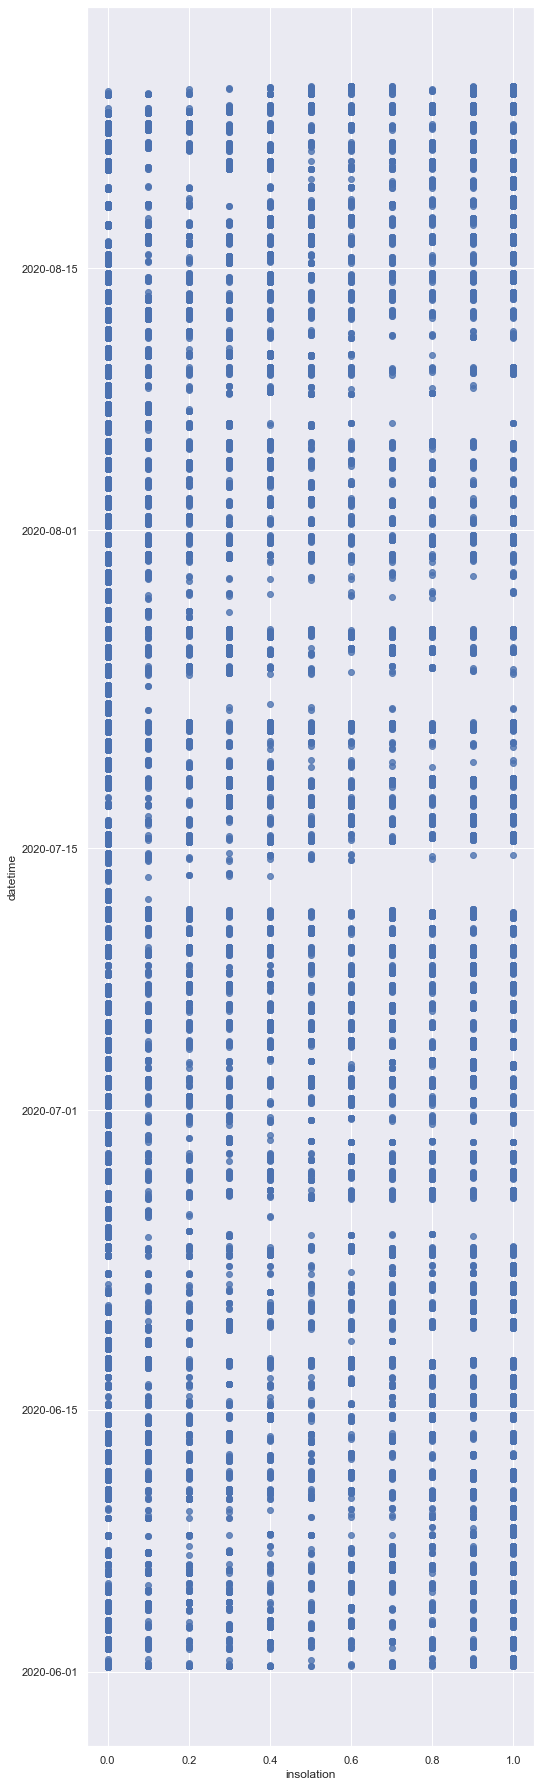

In [99]:
sns.set(rc = {'figure.figsize':(8,32)})

sns.regplot(x=daytime_not_rainy_df['insolation'], y=daytime_not_rainy_df['datetime'], 
           fit_reg=False)

datetime이 시간대별로 되어 있어서, 데이터의 분포를 전체적으로 알아보기가 힘들었습니다. 일자별로 일조량의 평균을 구한 다음, 그걸 scatter 그래프로 그려보았습니다.

In [100]:
perDay_insolation = pd.DataFrame()
perDay_insolation['datetime'] = daytime_not_rainy_df['datetime']
perDay_insolation['insolation'] = daytime_not_rainy_df['insolation']


In [101]:
perDay_insolation.head()

,datetime,insolation
7,2020-06-01 07:00:00,0.1
8,2020-06-01 08:00:00,0.3
9,2020-06-01 09:00:00,0.7
10,2020-06-01 10:00:00,1.0
11,2020-06-01 11:00:00,1.0


In [102]:
# perDay_insolation['datetime']=perDay_insolation['datetime'].astype(str)+'-'
perDay_insolation['mm-dd']=perDay_insolation['datetime'].dt.month
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6
8,2020-06-01 08:00:00,0.3,6
9,2020-06-01 09:00:00,0.7,6
10,2020-06-01 10:00:00,1.0,6
11,2020-06-01 11:00:00,1.0,6


In [103]:
perDay_insolation['mm-dd']=perDay_insolation['mm-dd'].astype(str)+'/'
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6/
8,2020-06-01 08:00:00,0.3,6/
9,2020-06-01 09:00:00,0.7,6/
10,2020-06-01 10:00:00,1.0,6/
11,2020-06-01 11:00:00,1.0,6/


In [104]:
perDay_insolation['mm-dd']=perDay_insolation['mm-dd'].astype(str) + perDay_insolation['datetime'].dt.day.astype(str)

In [105]:
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6/1
8,2020-06-01 08:00:00,0.3,6/1
9,2020-06-01 09:00:00,0.7,6/1
10,2020-06-01 10:00:00,1.0,6/1
11,2020-06-01 11:00:00,1.0,6/1


In [106]:
perDay_insolation.groupby('mm-dd')['insolation'].mean().round(3)

mm-dd
6/1     0.791
6/10    0.618
6/11    0.552
6/12    0.123
6/13    0.558
        ...  
8/5     0.159
8/6     0.071
8/7     0.009
8/8     0.114
8/9     0.391
Name: insolation, Length: 85, dtype: float64

<AxesSubplot:xlabel='insolation'>

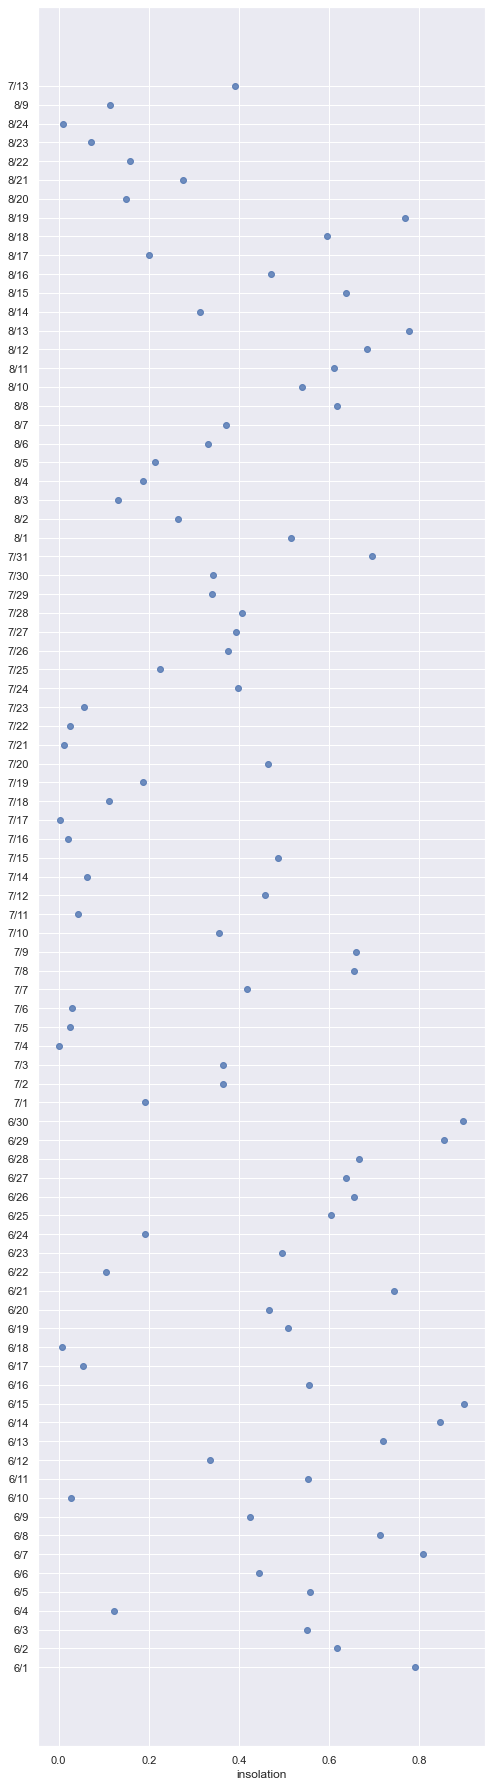

In [107]:
sns.set(rc = {'figure.figsize':(8,32)})

sns.regplot(y=perDay_insolation['mm-dd'].unique(), x = perDay_insolation.groupby('mm-dd')['insolation'].mean().round(3),
           fit_reg=False)

맑은날과 흐린날을 구별할 기준을 정하기 위해 위와 같은 그래프를 그려보았습니다.
강수량이 0인날에, 일별로 모든 건물들의 일조량의 평균을 구한 것입니다.

흐린날과 맑은날을 어떻게 나눌지에 대해 저희 조에서 의견을 나눈 결과 일조량의 평균이 0.2이하면 흐린날, 나머지는 맑은 날로 결정하였습니다.

그래프를 보고 임의로 기준을 나눈 것인데, 정확한 기준점을 찾아보려 했으나 회의결과 임의로 나누는 것이 낫겠다라는 결론이 나서 저희 조 만의 임의의 기준을 사용하였습니다. 아래는 회의록입니다.

(더쓸것임)

- 기상청 운량 데이터 사용하기

- 탐색적 요인 분석 사용해보기

https://starfield.tistory.com/1024

https://web.kma.go.kr/weather/climate/past_table.jsp?stn=108&yy=2020&obs=59&x=6&y=16

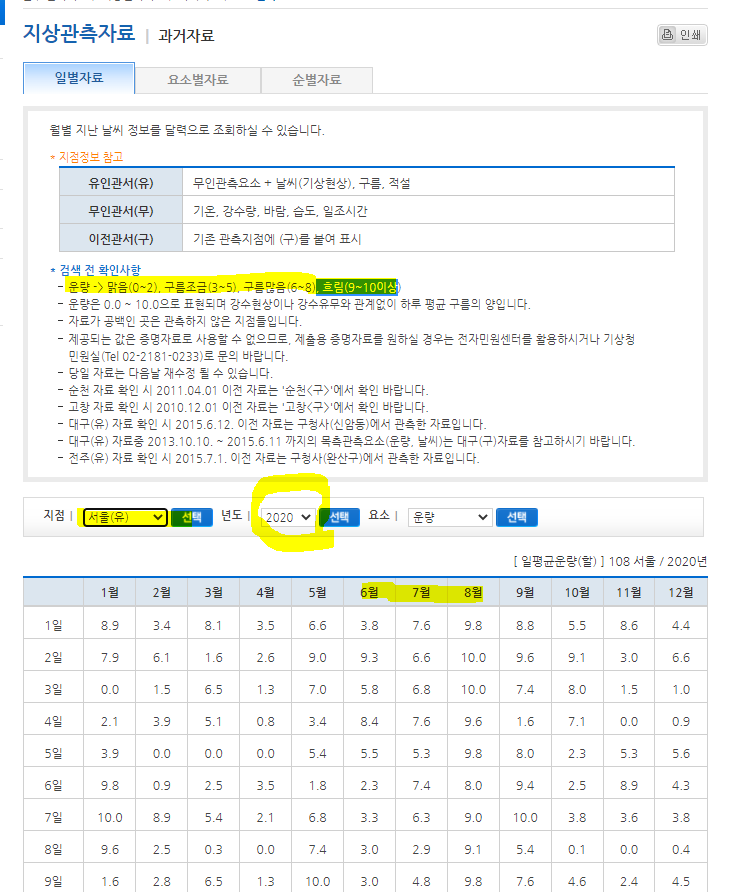


https://hleecaster.com/python-factor-analysis/

In [108]:
daytime_not_rainy_df['weather'] = ['sunny' if s >0.3 else 'cloudy' for s in daytime_not_rainy_df['insolation']]
daytime_not_rainy_df.head(100)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7,cloudy
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8,cloudy
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9,sunny
10,1,2020-06-01 10:00:00,8116.200,20.5,3.4,62.0,0.0,1.0,0.0,0.0,10,sunny
11,1,2020-06-01 11:00:00,8104.536,22.1,3.6,52.0,0.0,1.0,0.0,0.0,11,sunny
...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,2020-06-08 14:00:00,8668.944,30.6,2.9,44.0,0.0,1.0,0.0,0.0,14,sunny
183,1,2020-06-08 15:00:00,8679.312,31.2,2.2,41.0,0.0,1.0,0.0,0.0,15,sunny
184,1,2020-06-08 16:00:00,8722.728,31.6,2.8,43.0,0.0,1.0,0.0,0.0,16,sunny
185,1,2020-06-08 17:00:00,8708.472,30.7,3.8,45.0,0.0,1.0,0.0,0.0,17,sunny


In [109]:
daytime_not_rainy_df.shape

(56002, 12)

In [110]:
nightTime_not_rainy_df.shape

(47471, 11)

In [111]:
rainy_df.shape

(18927, 12)

In [112]:
humid_avg_day = daytime_not_rainy_df.groupby('weather').mean('humidity')

In [113]:
humid_avg_day['humidity']

weather
cloudy    81.697834
sunny     63.442516
Name: humidity, dtype: float64

In [114]:
nightTime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19


In [115]:
nightTime_not_rainy_df[nightTime_not_rainy_df['insolation']!=0]

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19
20,1,2020-06-01 20:00:00,7994.376,19.8,2.5,51.0,0.0,0.4,0.0,0.0,20
67,1,2020-06-03 19:00:00,8461.584,23.8,4.8,68.0,0.0,0.8,0.0,0.0,19
115,1,2020-06-05 19:00:00,8657.280,25.8,3.3,60.0,0.0,0.4,0.0,0.0,19
163,1,2020-06-07 19:00:00,8612.568,24.5,3.3,67.0,0.0,0.9,0.0,0.0,19
...,...,...,...,...,...,...,...,...,...,...,...
122275,60,2020-08-19 19:00:00,3985.200,26.4,2.5,81.0,0.0,0.8,1.0,1.0,19
122323,60,2020-08-21 19:00:00,3780.000,27.0,1.9,77.0,0.0,0.1,1.0,1.0,19
122347,60,2020-08-22 19:00:00,3688.848,25.2,2.0,86.0,0.0,0.6,1.0,1.0,19
122371,60,2020-08-23 19:00:00,3808.512,26.5,1.9,62.0,0.0,0.7,1.0,1.0,19


일조량이 0이 아닌 데이터는 존재하지 않는 것을 확인했습니다

In [116]:
print(nightTime_not_rainy_df['humidity'].min(),
      nightTime_not_rainy_df['humidity'].max(),
      nightTime_not_rainy_df['humidity'].median(),
      nightTime_not_rainy_df['humidity'].mean())

19.0 100.0 86.0 82.9845463546165


In [117]:
nightTime_not_rainy_df['humidity'].describe()

count    47471.000000
mean        82.984546
std         12.643801
min         19.000000
25%         75.000000
50%         86.000000
75%         93.000000
max        100.000000
Name: humidity, dtype: float64

강수량 = 0 일조량 = 0 새벽시간 + 밤시간 (저녁시간) 온도 /습도 / 풍속 -> 
맑은날 / 흐린날을

- humidity > 95 : 흐린날로 하자

- 불쾌지수를 계산해서 불쾌지수가 높은날을 흐린날로하자

- 온도와 습도의 관계를 구해서 결정해보자!

회의결과 humidity > 95인것을 흐린날로 표기하기로 하였음.

In [118]:
nightTime_not_rainy_df[nightTime_not_rainy_df['humidity']>90].count()

num                15663
datetime           15663
target             15663
temperature        15663
windspeed          15663
humidity           15663
precipitation      15663
insolation         15663
nelec_cool_flag    15663
solar_flag         15663
hour               15663
dtype: int64

In [119]:
nightTime_not_rainy_df.count()

num                47471
datetime           47471
target             47471
temperature        47471
windspeed          47471
humidity           47471
precipitation      47471
insolation         47471
nelec_cool_flag    47471
solar_flag         47471
hour               47471
dtype: int64

In [120]:
nightTime_not_rainy_df['weather'] = ['sunny' if s <90 else 'cloudy' for s in nightTime_not_rainy_df['humidity']]
nightTime_not_rainy_df.head(100)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,cloudy
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,cloudy
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,cloudy
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,cloudy
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19,sunny
...,...,...,...,...,...,...,...,...,...,...,...,...
215,1,2020-06-09 23:00:00,8609.328,25.2,2.3,53.0,0.0,0.0,0.0,0.0,23,sunny
216,1,2020-06-10 00:00:00,8602.848,24.6,1.6,52.0,0.0,0.0,0.0,0.0,0,sunny
217,1,2020-06-10 01:00:00,8562.024,24.3,1.2,54.0,0.0,0.0,0.0,0.0,1,sunny
218,1,2020-06-10 02:00:00,8561.376,23.9,0.6,55.0,0.0,0.0,0.0,0.0,2,sunny


In [121]:
sunny_cloudy_df = pd.concat([nightTime_not_rainy_df, daytime_not_rainy_df])

In [122]:
print(not_rainy_df.shape, sunny_cloudy_df.shape)

(103473, 11) (103473, 12)


# 기존 비안온날의 데이터 프레임과 비교했을때 한개의 column만 추가된 것을 확인.

weather

In [123]:
sunny_cloudy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,cloudy
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,cloudy
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,cloudy
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,cloudy
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19,sunny


In [124]:
added_weather_df = pd.concat([sunny_cloudy_df,rainy_df])

In [125]:
print(train_df.shape, added_weather_df.shape)

(122400, 10) (122400, 12)


# 원본 데이터 프레임과 비교했을때 두개의 column만 추가된 것을 확인.
(hour, weather)

In [126]:
added_weather_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,cloudy
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,cloudy
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,cloudy
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,cloudy
19,1,2020-06-01 19:00:00,8028.072,21.3,4.2,44.0,0.0,1.0,0.0,0.0,19,sunny


In [127]:
added_weather_df=added_weather_df.sort_index()

In [129]:
added_weather_df[50:100]

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
50,1,2020-06-03 02:00:00,8090.280,18.2,1.8,89.0,0.0,0.0,0.0,0.0,2,sunny
51,1,2020-06-03 03:00:00,8091.576,18.2,1.3,89.0,0.0,0.0,0.0,0.0,3,sunny
52,1,2020-06-03 04:00:00,8057.880,18.1,1.5,87.0,0.0,0.0,0.0,0.0,4,sunny
53,1,2020-06-03 05:00:00,8038.440,18.1,1.3,88.0,0.0,0.0,0.0,0.0,5,sunny
54,1,2020-06-03 06:00:00,8019.648,17.6,0.4,89.0,0.0,0.0,0.0,0.0,6,cloudy
55,1,2020-06-03 07:00:00,8094.816,18.3,1.8,88.0,0.0,0.3,0.0,0.0,7,cloudy
56,1,2020-06-03 08:00:00,8151.840,19.7,2.0,82.0,0.0,0.9,0.0,0.0,8,sunny
57,1,2020-06-03 09:00:00,8201.088,20.8,0.8,76.0,0.0,0.4,0.0,0.0,9,sunny
58,1,2020-06-03 10:00:00,8261.352,22.0,1.4,73.0,0.0,0.2,0.0,0.0,10,cloudy
59,1,2020-06-03 11:00:00,8278.200,23.1,2.2,68.0,0.0,0.3,0.0,0.0,11,cloudy
